In [1]:
from pyspark.sql import SparkSession

# Inicializa a sessão Spark
spark = SparkSession.builder \
    .appName("FraudDetection") \
    .getOrCreate()

# Carrega o dataset (header - para pegar primeira linha como cabeçalho, inferSchema - para inferir o tipo de dado de cada coluna)
df = spark.read.csv("dataset/Final-Transactions.csv", header=True, inferSchema=True)

# Exibe o esquema e as primeiras linhas do DataFrame
df.printSchema()
df.show(5)


root
 |-- _c0: integer (nullable = true)
 |-- TRANSACTION_ID: integer (nullable = true)
 |-- TX_DATETIME: timestamp (nullable = true)
 |-- CUSTOMER_ID: integer (nullable = true)
 |-- TERMINAL_ID: integer (nullable = true)
 |-- TX_AMOUNT: double (nullable = true)
 |-- TX_TIME_SECONDS: integer (nullable = true)
 |-- TX_TIME_DAYS: integer (nullable = true)
 |-- TX_FRAUD: integer (nullable = true)
 |-- TX_FRAUD_SCENARIO: integer (nullable = true)

+---+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|_c0|TRANSACTION_ID|        TX_DATETIME|CUSTOMER_ID|TERMINAL_ID|TX_AMOUNT|TX_TIME_SECONDS|TX_TIME_DAYS|TX_FRAUD|TX_FRAUD_SCENARIO|
+---+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|  0|             0|2023-01-01 00:00:31|        596|       3156|   533.07|             31|           0|       0|                0|
|  1|             1|2023-01-

+--------+-------+
|TX_FRAUD|  count|
+--------+-------+
|       1| 229588|
|       0|1478204|
+--------+-------+



C:\Users\pedro\AppData\Local\Temp\ipykernel_18112\924738383.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TX_FRAUD', y='count', data=pandas_counts, palette="Set2")


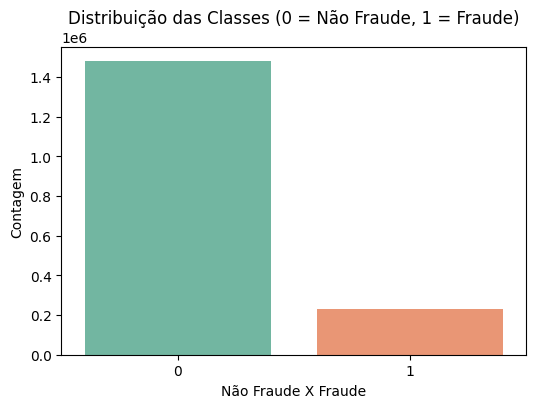

In [2]:
# Contagem de transações por classe (0 = Não Fraude, 1 = Fraude)
class_counts = df.groupBy("TX_FRAUD").count()
class_counts.show()

# Converte para Pandas para visualizar com gráficos
pandas_counts = class_counts.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.barplot(x='TX_FRAUD', y='count', data=pandas_counts, palette="Set2")
plt.title("Distribuição das Classes (0 = Não Fraude, 1 = Fraude)")
plt.xlabel("Não Fraude X Fraude")
plt.ylabel("Contagem")
plt.show()


#### Observação: Devido ao baixo número de fraudes, a distribuição do "TX_AMOUNT" pode mostrar variações específicas.

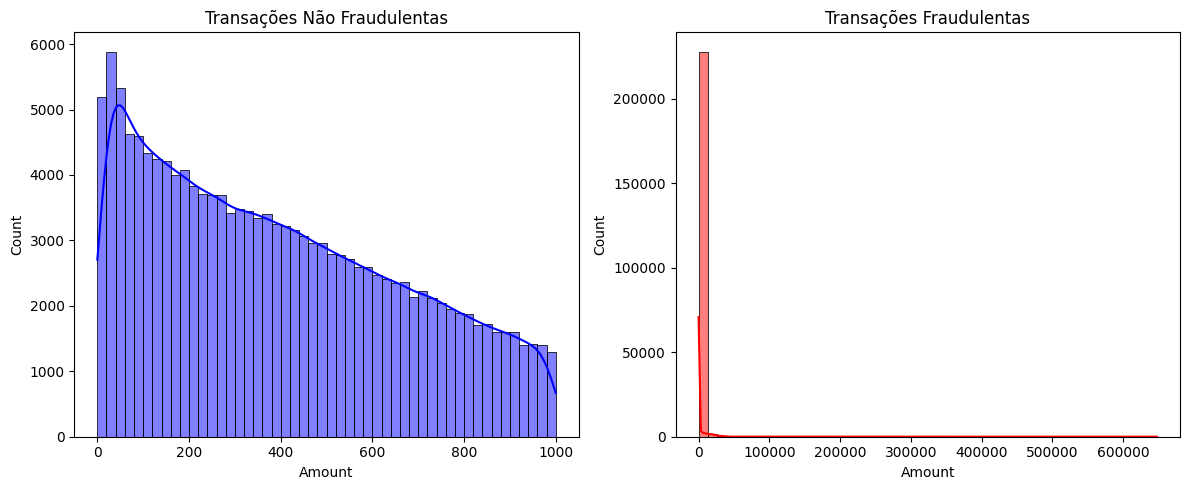

In [3]:
# Para transações não fraudulentas, amostramos 10% dos dados
nonfraud_pd = df.filter(df.TX_FRAUD == 0).select("TX_AMOUNT").sample(fraction=0.1, seed=42).toPandas()

# Para transações fraudulentas (sendo poucas), coletamos todos os registros
fraud_pd = df.filter(df.TX_FRAUD == 1).select("TX_AMOUNT").toPandas()

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.histplot(nonfraud_pd['TX_AMOUNT'], bins=50, color="blue", kde=True)
plt.title("Transações Não Fraudulentas")
plt.xlabel("Amount")

plt.subplot(1, 2, 2)
sns.histplot(fraud_pd['TX_AMOUNT'], bins=50, color="red", kde=True)
plt.title("Transações Fraudulentas")
plt.xlabel("Amount")
plt.tight_layout()
plt.show()


#### Eixo X: Valor da transação (Amount).
#### Eixo Y: Quantidade (contagem) de transações ocorrendo em cada faixa de valor.
##### Gráfico da esquerda (azul): Distribuição de valores para transações não fraudulentas.
##### Gráfico da direita (vermelho): Distribuição de valores para transações fraudulentas.
##### Esses gráficos mostram se as fraudes tendem a ocorrer em valores menores ou maiores em comparação às transações legítimas, ou se há uma concentração em faixas específicas de valor.

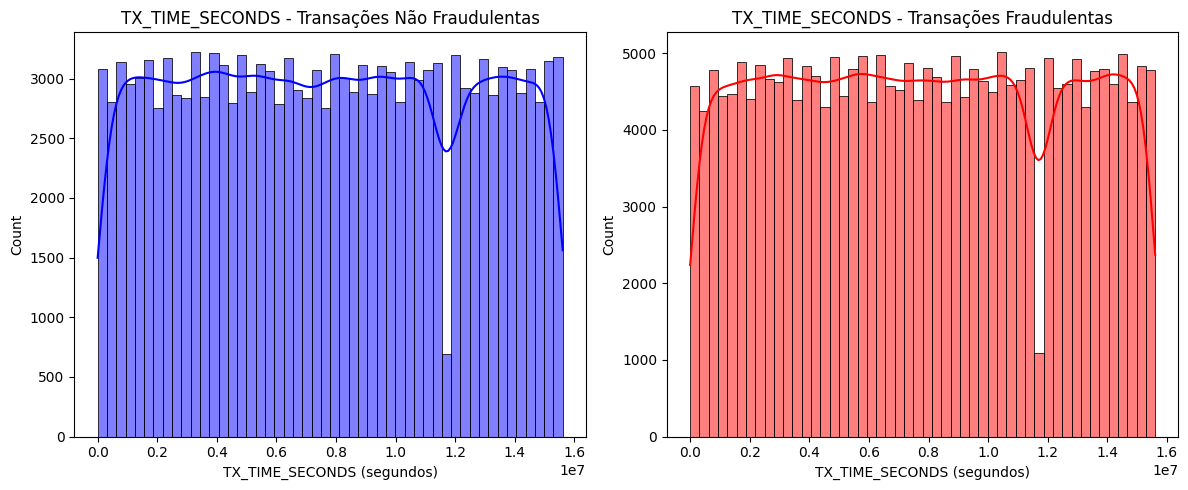

In [4]:
# Análise similar para a variável 'TX_TIME_SECONDS'
nonfraud_time = df.filter(df.TX_FRAUD == 0).select("TX_TIME_SECONDS").sample(fraction=0.1, seed=42).toPandas()
fraud_time = df.filter(df.TX_FRAUD == 1).select("TX_TIME_SECONDS").toPandas()

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.histplot(nonfraud_time['TX_TIME_SECONDS'], bins=50, color="blue", kde=True)
plt.title("TX_TIME_SECONDS - Transações Não Fraudulentas")
plt.xlabel("TX_TIME_SECONDS (segundos)")

plt.subplot(1, 2, 2)
sns.histplot(fraud_time['TX_TIME_SECONDS'], bins=50, color="red", kde=True)
plt.title("TX_TIME_SECONDS - Transações Fraudulentas")
plt.xlabel("TX_TIME_SECONDS (segundos)")
plt.tight_layout()
plt.show()

#### Eixo X: Tempo da transação em segundos (TX_TIME_SECONDS).
#### Eixo Y: Quantidade (contagem) de transações ocorrendo naquele intervalo de tempo.
##### Gráfico da esquerda (azul): Distribuição de transações não fraudulentas ao longo do tempo.
##### Gráfico da direita (vermelho): Distribuição de transações fraudulentas ao longo do tempo.
##### Esses gráficos ajudam a verificar se existem períodos do dia (ou intervalos de tempo) em que as fraudes se concentram mais ou menos em comparação às transações verdadeiras.
##### E como podemos ver, não há muita diferença em relação a períodos do dia (ou intervalos de tempo).

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Seleciona as colunas numéricas (ajuste conforme necessário)
# Neste exemplo, vamos incluir todas as colunas, exceto 'TX_FRAUD' e 'TX_DATETIME'
numeric_cols = [col for col in df.columns if col not in ["TX_FRAUD", "TX_DATETIME"]]

# Combina as colunas em um vetor de features
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df.select(numeric_cols))

# Calcula a matriz de correlação
correlation_matrix = Correlation.corr(df_vector, "features").head()[0]
print("Matriz de Correlação:\n")
print(correlation_matrix.toArray())

Py4JJavaError: An error occurred while calling z:org.apache.spark.ml.stat.Correlation.corr.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 14 in stage 14.0 failed 1 times, most recent failure: Lost task 14.0 in stage 14.0 (TID 159) (DESKTOP-3L408NC executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda/0x000001deb4fccc90`: (struct<_c0_double_VectorAssembler_a56d5a626a8c:double,TRANSACTION_ID_double_VectorAssembler_a56d5a626a8c:double,CUSTOMER_ID_double_VectorAssembler_a56d5a626a8c:double,TERMINAL_ID_double_VectorAssembler_a56d5a626a8c:double,TX_AMOUNT:double,TX_TIME_SECONDS_double_VectorAssembler_a56d5a626a8c:double,TX_TIME_DAYS_double_VectorAssembler_a56d5a626a8c:double,TX_FRAUD_SCENARIO_double_VectorAssembler_a56d5a626a8c:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1264)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1265)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 39 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2488)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1202)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1196)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1289)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1256)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1242)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1242)
	at org.apache.spark.mllib.stat.Statistics$.colStats(Statistics.scala:58)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.computeCovariance(RowMatrix.scala:456)
	at org.apache.spark.mllib.stat.correlation.PearsonCorrelation$.computeCorrelationMatrix(PearsonCorrelation.scala:49)
	at org.apache.spark.mllib.stat.correlation.Correlations$.corrMatrix(Correlation.scala:66)
	at org.apache.spark.mllib.stat.Statistics$.corr(Statistics.scala:90)
	at org.apache.spark.ml.stat.Correlation$.corr(Correlation.scala:71)
	at org.apache.spark.ml.stat.Correlation.corr(Correlation.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda/0x000001deb4fccc90`: (struct<_c0_double_VectorAssembler_a56d5a626a8c:double,TRANSACTION_ID_double_VectorAssembler_a56d5a626a8c:double,CUSTOMER_ID_double_VectorAssembler_a56d5a626a8c:double,TERMINAL_ID_double_VectorAssembler_a56d5a626a8c:double,TX_AMOUNT:double,TX_TIME_SECONDS_double_VectorAssembler_a56d5a626a8c:double,TX_TIME_DAYS_double_VectorAssembler_a56d5a626a8c:double,TX_FRAUD_SCENARIO_double_VectorAssembler_a56d5a626a8c:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1264)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1265)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 39 more


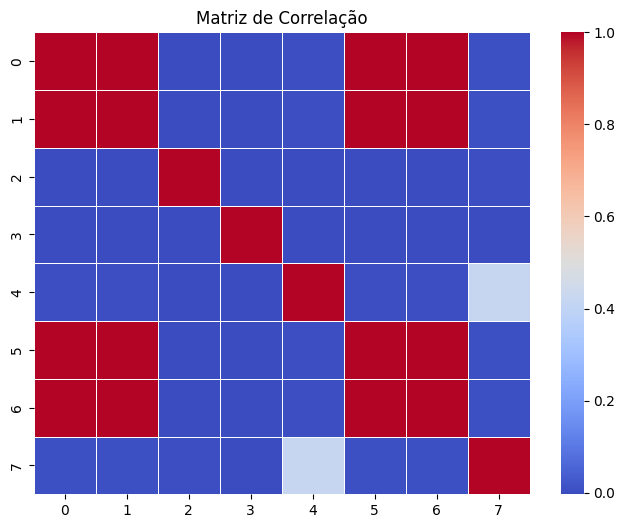

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix.toArray(), cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlação")
plt.show()

In [ ]:
# remoção de duplicados e valores nulos
df_clean = df.dropDuplicates()
df_clean = df_clean.dropna()
df_clean = df_clean.drop("TX_DATETIME")

In [ ]:
from pyspark.sql.functions import when, lit

#  "TX_FRAUD" é 0 (não fraude) ou 1 (fraude)
count_total = df_clean.count()
count_fraude = df_clean.filter(df_clean.TX_FRAUD == 1).count()
count_nao_fraude = count_total - count_fraude

# Peso para fraudes
fraude_weight = count_nao_fraude / count_fraude

# Cria a coluna "classWeightCol"
df_weighted = df_clean.withColumn(
    "classWeightCol",
    when(df_clean.TX_FRAUD == 1, fraude_weight).otherwise(1.0)
)

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

feature_cols = [col for col in df_weighted.columns if col not in ["TX_FRAUD", "classWeightCol"]]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="scaledFeatures",
    labelCol="TX_FRAUD",
    weightCol="classWeightCol",  # para lidar com desbalanceamento
    maxIter=10
)

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[assembler, scaler, lr])

# Divide em treino e teste
train_df, test_df = df_weighted.randomSplit([0.7, 0.3], seed=42)

# Treina o modelo
model = pipeline.fit(train_df)

In [ ]:
predictions = model.transform(test_df)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="TX_FRAUD",
    rawPredictionCol="prediction",  # ou "rawPrediction", dependendo do modelo
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(predictions)
print(f"AUC = {auc:.4f}")

# Para outras métricas (Precision/Recall), podemos usar o MulticlassClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

precision_eval = MulticlassClassificationEvaluator(
    labelCol="TX_FRAUD", 
    predictionCol="prediction", 
    metricName="precisionByLabel"  # ou "recallByLabel", "f1"
)
precision = precision_eval.evaluate(predictions)
print(f"Precision = {precision:.4f}")

AUC = 1.0000
Precision = 1.0000
